In [23]:
import re
import numpy as np
import pandas as pd
import csv
from pprint import pprint
import math

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import word_tokenize



# Plotting tools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [28]:
#load training Data
with open('C:/Users/flori/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs/idocnade/training.csv', newline='') as csvfile1:
    data_train = pd.read_csv(csvfile1,  names=["Label", "Text"])
    data_train = data_train.dropna(subset=['Text'])   

#load validation Data
with open('C:/Users/flori/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs/idocnade/validation.csv', newline='') as csvfile2:
    data_val = pd.read_csv(csvfile2,  names=["Label", "Text"])
    data_val = data_val.dropna(subset=['Text'])     
    
frames = [data_train,data_val]
train_data = pd.concat(frames)

#load testing Data
with open('C:/Users/flori/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20subs/idocnade/test.csv', newline='') as csvfile3:
    data_test = pd.read_csv(csvfile3,  names=["Label", "Text"])  
    data_test = data_test.dropna(subset=['Text'])  

In [25]:
def LdaPipeline(train_fold, val_fold, k):

    dictionary = gensim.corpora.Dictionary(train_fold["Text"].str.split())
    corpus_train = [dictionary.doc2bow(text.split()) for index,text in train_fold["Text"].iteritems()]
    corpus_val = [dictionary.doc2bow(text.split()) for index,text in val_fold["Text"].iteritems()]
    # LDA
    lda_model = gensim.models.LdaMulticore(corpus=corpus_train, id2word = dictionary, num_topics = k, alpha=0.1,workers=15)
    
    # Perplexity
    perplexity = lda_model.log_perplexity(corpus_val)
   
    # Coherence
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus_val]
    coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus_train, texts = texts,coherence='c_v')
    coherence = coherence_model.get_coherence()
    return [2**(-perplexity), coherence]



In [4]:
START = 2
STEP = 1
END = 200


In [5]:
#generate different LDA-Models
coherence_values = []
ppl_values = []
for k in tqdm(range(START, END, STEP)):
    ppl, cv = LdaPipeline(data_train,  data_val,k)
    coherence_values.append(cv)
    ppl_values.append(ppl)

C:\Users\flori\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\flori\Anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


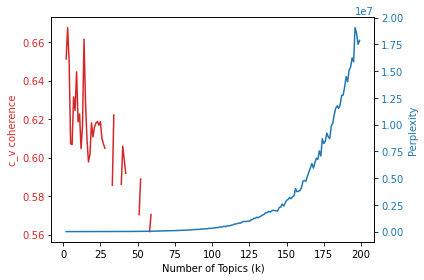

In [6]:
# Show graph

x = range(START, END, STEP)
fig, ax1 = plt.subplots()
#ppls = [math.exp(p) for p in ppl_values]

color = 'tab:red'
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('c_v coherence', color=color)
ax1.plot(x, coherence_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)  
ax2.plot(x, ppl_values, color=color) #use ppls instead of ppl_values for true Perplexity instead of lower bound
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [7]:
maxvalue = max(coherence_values)
print("Maximum Coherence_Value in the list is:", maxvalue)
#Now we have find the position of Max Value
maxpos = coherence_values.index(maxvalue)
print("This value is achieved when using k = "+str(2+maxpos)+" topic-clusters")

Maximum Coherence_Value in the list is: 0.6675125302285766
This value is achieved when using k = 3 topic-clusters


In [45]:
# Evaluate Model with best hyperparameter for k
#ppl0, cv0 = LdaPipeline(train_data,  data_test,2+maxpos)
#print("Perplexity: "+str(ppl0)+" and Coherence: "+str(cv0))    


### for COMPARISON with other setups
#ppl1, cv1 = LdaPipeline(train_data,  data_test,20)
#print("k = 20; Perplexity: "+str(ppl1)+" and Coherence: "+str(cv1)) 

#ppl2, cv2 = LdaPipeline(train_data,  data_test,50)
#print("k= 50; Perplexity: "+str(ppl2)+" and Coherence: "+str(cv2)) 

ppl3, cv3 = LdaPipeline(train_data,  data_test,100)
print("k = 100; Perplexity: "+str(ppl3)+" and Coherence: "+str(cv3)) 

#ppl4, cv4 = LdaPipeline(train_data,  data_test,200)
#print("k = 200; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)) 

k = 100; Perplexity: 4325.8382828576505 and Coherence: 0.6321355696220464


In [60]:
ppl4, cv4 = LdaPipeline(train_data,  data_test,200)
print("k = 200; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)) 

k = 200; Perplexity: 23895.70260477548 and Coherence: nan


In [ ]:
### visualize all results
from astropy.table import QTable, Table, Column
from astropy import units as u

data_rows = [#(2+maxpos, ppl0, cv0),
             (20, ppl1, cv1),
             (50, ppl2, cv2),
             (100, ppl3, cv3),
             (200, ppl4, cv4)]
t = Table(rows=data_rows, names=('k', 'Perplexity', 'Coherence c_v'))
print(t)

In [10]:
ppl_bound = np.log(ppl0)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [11]:
ppl_bound

5.301150550107789

In [12]:
2**(-ppl_bound)

0.02536265258884713